<h2>Mood Prediction</h2>

This project is all about predicting moods from the images using Neural Networks. 

Procedure and Observations: 

I collected my data from google using extension 'Download All Images'. This is easy to use but may contain some noisy data that should be eliminated mannualy. eg : search for photo of a man but some photo of women is also downloaded

Resize the image so as to avoid dimensionality errors, also images can not be opened are removed. Also used Data Argumentation to be more generalized.

I used CNN(Convolutional Neural Network) to predict the mood of a person. 3-Convolutional and 3-Dense Layers are used in Model that can be seen in 'model_structure.png' file. 

On testing the model, I got accuracy of 98%, while for live predictions model was performing very well.

Due to hardware constraints it was not possible for me to make more dense layer network while it can be clearly observed from the 'Accuracy' and 'Loss' curve that more Dense and Convolutional layers are required.

Stored my model as 'imageclassifier.h5'

Importing Libraries

In [235]:
import tensorflow as tf
import os

import cv2
import imghdr

import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


Enabling TensorFlow to allocate GPU memory dynamically

In [236]:
# This code enables memory growth, which allows TensorFlow to allocate GPU memory dynamically as needed.

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Removing Images that can not be accessed


In [237]:
data_dir = 'data' # name of folder/directory of stored data

image_exts = ['jpeg','jpg', 'bmp', 'png'] # all extensions used in image

# access directory
for image_class in os.listdir(data_dir): 
    # access image_classes folder('happy', 'sad')
    for image in os.listdir(os.path.join(data_dir, image_class)):
        # access all the images in image_class folder
        image_path = os.path.join(data_dir, image_class, image)
        # trying to read image if not possible print Issue
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Importing Data

In [238]:
# getting all the dataset
data = tf.keras.utils.image_dataset_from_directory('data',
                                                   image_size=(256, 256),  # Resize images to 256x256
                                                   batch_size=20,          # Batch size
                                                   shuffle=True            # Shuffle data
                                                   )

Found 305 files belonging to 2 classes.


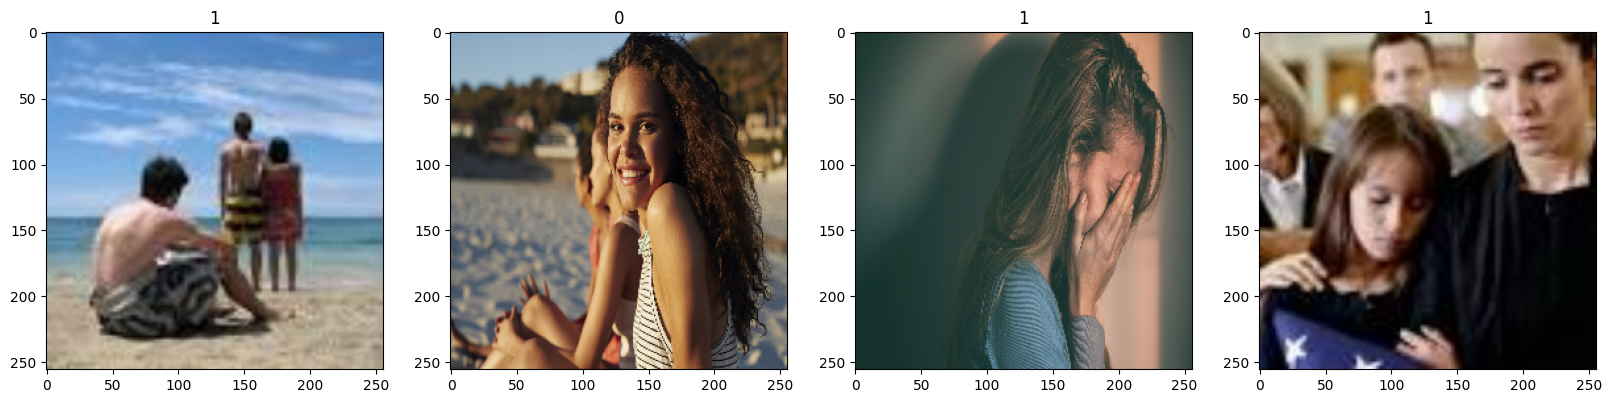

In [239]:
data_iterator = data.as_numpy_iterator() #  to iterate through the data and extract batches in the form of NumPy arrays

batch = data_iterator.next() #Retrieves the next batch of data from the iterator

# plotting some images with their labels
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
# class label = { 'sad' : 1, 'happy' : 0 }

Creating Argumented Data

In [240]:
def augment_image(image, label):
    # Data augmentation
    image = tf.image.random_flip_left_right(image)     # Randomly flip image horizontally
    image = tf.image.random_flip_up_down(image)        # Randomly flip image vertically
    image = tf.image.random_brightness(image, max_delta=0.2)  # Randomly adjust brightness
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)  # Randomly adjust contrast
    image = tf.image.random_hue(image, max_delta=0.1)  # Randomly adjust hue
    image = tf.image.random_saturation(image, lower=0.2, upper=0.5)  # Randomly adjust saturation
    return image, label


In [241]:
# data = data.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)


In [242]:
# Create a data iterator
data_iterator = data.as_numpy_iterator()

# Retrieve a batch of data
batch = data_iterator.next()

# Print batch shapes and labels
print(f"Batch of images shape: {batch[0].shape}")
print(f"Batch of labels shape: {batch[1].shape}")


Batch of images shape: (20, 256, 256, 3)
Batch of labels shape: (20,)


Preprocessing Data

In [243]:
# scaling data to get all values beteween 0 and 1
data = data.map(lambda x,y: (x/255, y))

In [244]:
data.as_numpy_iterator().next()[0][0] # 1 image representation as np array

array([[[0.6732293 , 0.6593076 , 0.6618499 ],
        [0.6869108 , 0.6728339 , 0.67630935],
        [0.6853183 , 0.6711653 , 0.67469203],
        ...,
        [0.73728055, 0.71386856, 0.7089774 ],
        [0.7403043 , 0.71599174, 0.71158695],
        [0.7320936 , 0.70825946, 0.7035963 ]],

       [[0.66851443, 0.6544229 , 0.6576897 ],
        [0.67378503, 0.6598634 , 0.6632341 ],
        [0.67996395, 0.6660423 , 0.66941303],
        ...,
        [0.7421149 , 0.718703  , 0.71381176],
        [0.7389896 , 0.71557766, 0.7106865 ],
        [0.73417914, 0.71074474, 0.7060442 ]],

       [[0.68484616, 0.67009616, 0.6740255 ],
        [0.6735699 , 0.66085935, 0.6636152 ],
        [0.6760319 , 0.66211027, 0.665481  ],
        ...,
        [0.7409855 , 0.7175736 , 0.71268237],
        [0.74190277, 0.71849084, 0.7135996 ],
        [0.73804843, 0.7141316 , 0.70951307]],

       ...,

       [[0.5905486 , 0.5594753 , 0.55393726],
        [0.59147483, 0.5602613 , 0.5540593 ],
        [0.5942506 , 0

In [245]:
# splitting data into train(70%), test(10%) and validation(20%) sets

# deciding size
train_size = int(len(data)*.7) 
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

# splitting
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [246]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Building Model

In [247]:
# using sequential model
model = Sequential()

In [248]:
# adding 3 2D-convolutional layers with max_pooling
model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# flatten layer
model.add(Flatten())

# dense layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # getting probability as output

In [249]:
# using 'Adam' for backpropagation and BinaryCrossentropy as loss_function
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

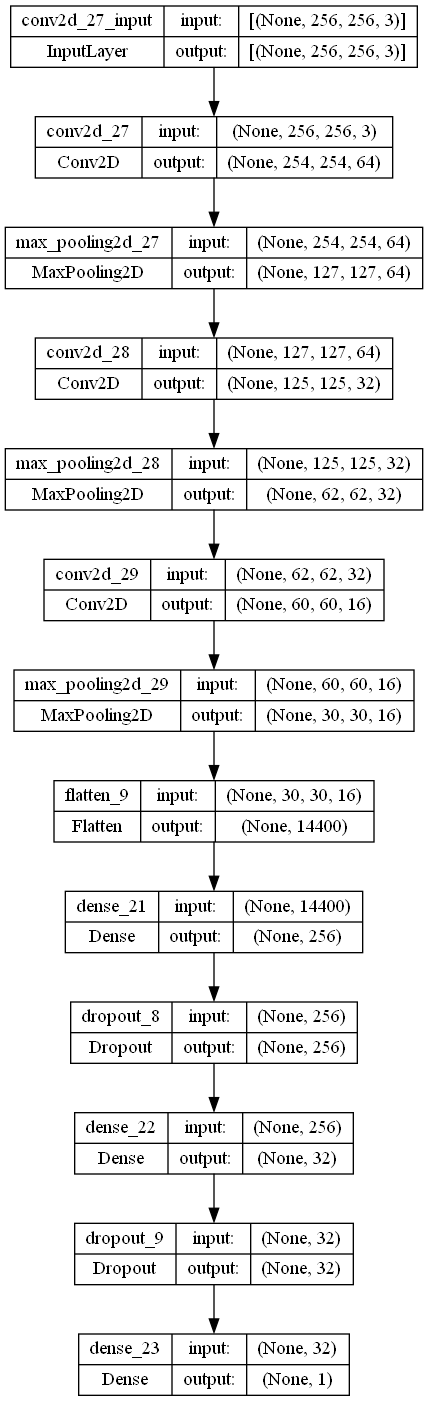

In [250]:
# Save the model architecture diagram to a file
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [251]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 30, 30, 16)      

Creating Logs Directory

In [252]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Training Model

In [253]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
11/11 [==============================] - 44s 4s/step - loss: 0.8118 - accuracy: 0.4909 - val_loss: 0.6947 - val_accuracy: 0.4167
Epoch 2/40
11/11 [==============================] - 37s 3s/step - loss: 0.6783 - accuracy: 0.5273 - val_loss: 0.6785 - val_accuracy: 0.5333
Epoch 3/40
11/11 [==============================] - 33s 3s/step - loss: 0.6962 - accuracy: 0.5318 - val_loss: 0.6926 - val_accuracy: 0.4333
Epoch 4/40
11/11 [==============================] - 33s 3s/step - loss: 0.6846 - accuracy: 0.5591 - val_loss: 0.6433 - val_accuracy: 0.6167
Epoch 5/40
11/11 [==============================] - 40s 4s/step - loss: 0.6748 - accuracy: 0.5955 - val_loss: 0.6583 - val_accuracy: 0.6000
Epoch 6/40
11/11 [==============================] - 38s 3s/step - loss: 0.6899 - accuracy: 0.5545 - val_loss: 0.6791 - val_accuracy: 0.5667
Epoch 7/40
11/11 [==============================] - 35s 3s/step - loss: 0.6798 - accuracy: 0.5045 - val_loss: 0.6468 - val_accuracy: 0.5500
Epoch 8/40
11/11 [==

Evaluating Performance of Model

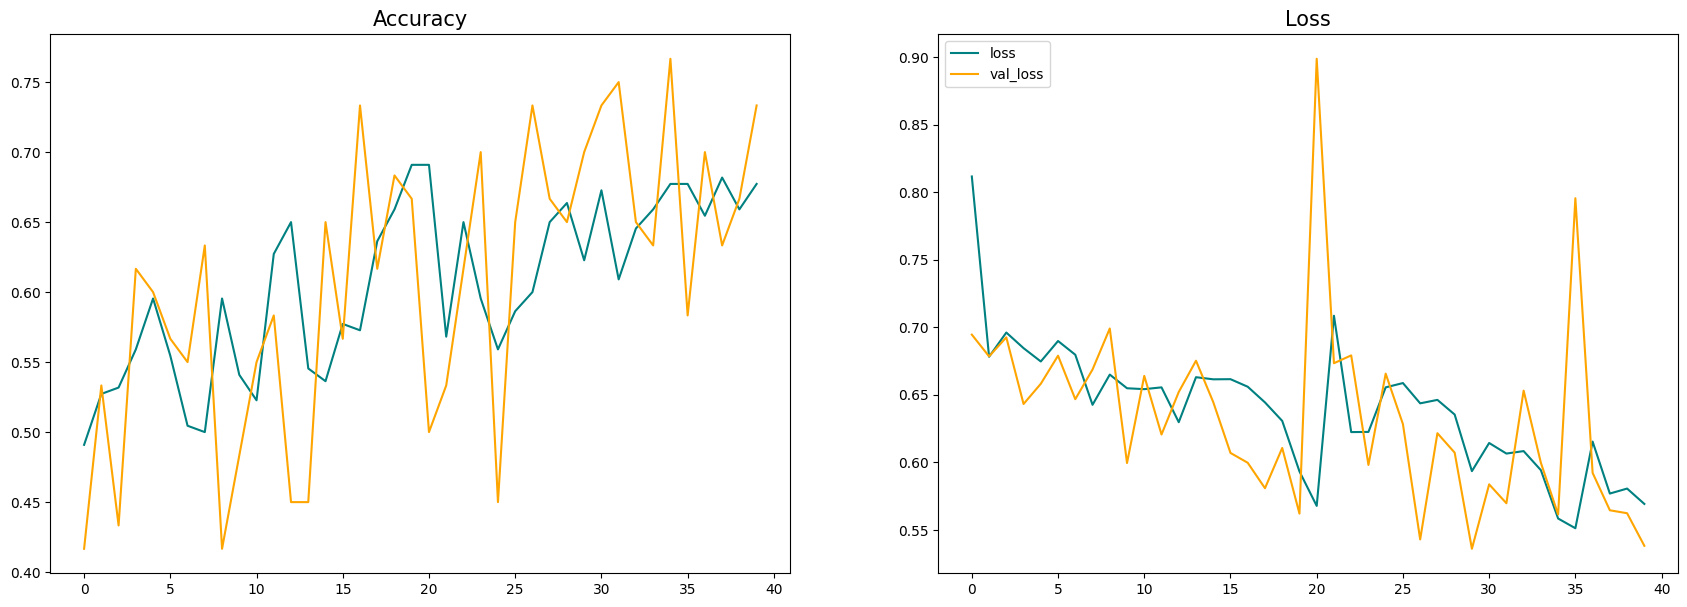

In [254]:
# observing Accuracy and loss

fig,ax = plt.subplots(ncols=2, figsize=(21,7))

ax[0].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[0].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[0].set_title('Accuracy', fontsize=15)

ax[1].plot(hist.history['loss'], color='teal', label='loss')
ax[1].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[1].set_title('Loss', fontsize=15)

plt.legend(loc="upper left")
plt.show()


In [255]:
# calculating precision, recall and accuracy score

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# iterating test data 
for batch in test.as_numpy_iterator(): 
    X, y = batch
    # making predictions for test data
    yhat = model.predict(X) 
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 883ms/step


In [256]:
print(f'Precision : {pre.result()}')
print(f'Recall    : {re.result()}')
print(f'Accuracy  : {acc.result()}')

Precision : 0.4545454680919647
Recall    : 0.8333333134651184
Accuracy  : 0.6499999761581421


Testing Random Data

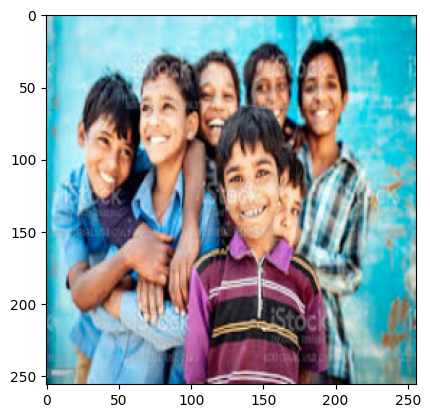

In [271]:
img_path = r"C:\Users\HP\Downloads\ImageClassification-main\ImageClassification-main\randomHappyImage.jpeg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [272]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(y)
if yhat > 0.5: 
    y_pred = yhat[0][0]
    print(f'Predicted class is Sad, Probability : {y_pred}')
else:
    y_pred = 1-yhat[0][0]
    print(f'Predicted class is Happy, Probability : {y_pred}')

1/1 [==============================] - 0s 71ms/step
[0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0]
Predicted class is Happy, Probability : 0.6890226602554321


Saving Model

In [259]:
model.save(os.path.join('models','imageclassifier.h5'))

Live Testing

In [260]:
# importing libraries
import cv2
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model(r'C:\Users\HP\Downloads\ImageClassification-main\ImageClassification-main\models\imageclassifier.h5')

label_mapping = {0: 'Sad', 1: 'Happy'}

# target image size 
IMAGE_SIZE = (256,256)

# Initialize webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    # if frame can be captured ok, else break loop  
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the frame to RGB (Mediapipe expects RGB input)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Convert back to BGR for rendering
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    resize = tf.image.resize(image_bgr, (256,256))
    
    # obtaining live predictions
    yhat = model.predict(np.expand_dims(resize/255, 0))
    
    if yhat > 0.5: 
        y_pred = yhat[0][0]
        text = f'Predicted class is Sad, Probability : {y_pred}'
    else:
        y_pred = 1-yhat[0][0]
        text = f'Predicted class is Happy, Probability : {y_pred}'
        
    # Show the main frame
    position = (50, 50)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    color = (0, 0, 255) 
    thickness = 1
    
    # Add text to the frame
    cv2.putText(image_bgr, str(text), position, font, font_scale, color, thickness, cv2.LINE_AA)

    cv2.imshow('Mood Detection', image_bgr)
    
    # Break the loop on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 72ms/step
